# Изучение закономерностей, определяющих успешность игр

<b>Что исследуем</b>: исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Двнные из открытых источников до 2016 года.

<b>Цель исследования</b> — проанализировать данные и выявить определяющие успешность игры закономерности. 
Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Что предстоит сделать:
1. Исследовать данные, чтобы:
- выбрать потенциально прибыльные платформы
- оценить влияние оценок на продажи
- выявить жанры с высокими и низкими продажами
2. Составить портреты пользователей по регионам (Северная Америка, Европа, Япония).
3. Проверить гипотезы:
- средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- средние пользовательские рейтинги жанров Action и Sports разные

### Загрузка данных

In [106]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
data = pd.read_csv('/datasets/games.csv') #сохранение таблицы с данными в переменную
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Описание данных:

- `Name` — название игры

- `Platform` — платформа

- `Year_of_Release` — год выпуска

- `Genre` — жанр игры

- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)

- `EU_sales` — продажи в Европе (миллионы проданных копий)

- `JP_sales` — продажи в Японии (миллионы проданных копий)

- `Other_sales` — продажи в других странах (миллионы проданных копий)

- `Critic_Score` — оценка критиков (максимум 100)

- `User_Score` — оценка пользователей (максимум 10)

- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Приведем названия столбцов к нижнему регистру и изучим общую информацию о данных.

In [108]:
data.columns = data.columns.str.lower() #приведение названий столбцов к нижнему регистру
data.info() #вывод общей информации о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В таблице есть пропуски в 6 столбцах. Два пропуска есть даже в столбце `name`, из-за чего полезность данных в таких строках под вопросом. Также есть столбцы, в которых нужно будет исправить тип данных. 

In [109]:
data.describe().T #вывод описательных статистик

,count,mean,std,min,25%,50%,75%,max
year_of_release,16446.0,2006.484616,5.877050,1980.0,2003.0,2007.00,2010.00,2016.00
na_sales,16715.0,0.263377,0.813604,0.0,0.0,0.08,0.24,41.36
eu_sales,16715.0,0.145060,0.503339,0.0,0.0,0.02,0.11,28.96
jp_sales,16715.0,0.077617,0.308853,0.0,0.0,0.00,0.04,10.22
other_sales,16715.0,0.047342,0.186731,0.0,0.0,0.01,0.03,10.57
critic_score,8137.0,68.967679,13.938165,13.0,60.0,71.00,79.00,98.00


На первый взгляд, нереалистичных минимальных и максимальных значений нет. Большой разбег по продажам пока не вызывает подозрений, т.к. игры действительно могут либо вовсе не продаваться, либо иметь очень успешные показатели. 

Среди числовых столбцов пока не хватает столбца `user_score`, т.к. данные в нем нужно будет привести в корректный формат. Изучим этот столбец позже.

### Предобработка данных

#### Изменение типов данных

Менять типы данных будем в столбцах:
- `year_of_release` с float на int, т.к. год выпуска может быть только целым числом
- `user_score` с object на float, т.к. оценка пользователей является числом, но значение может быть не целым, т.к. это средняя оценка 

In [110]:
data['year_of_release'] = data['year_of_release'].astype('Int64') #изменение типа данных в столбце с годом на int
data.info() #вывод общей информации о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB


В столбце с оценками пользователей невозможно одним действием изменить тип данных на нужный из-за встречающегося в нем значения tbd. Это означает to be determined (будет определено) или to be discussed (выносится на обсуждение), т.е. подразумевалось, что эти данные будут указаны позже, но по факту эти ячейки пусты. Поэтому я предлагаю заменить tbd на NaN, а после исправить тип данных в столбце.

In [111]:
data['user_score'] = data['user_score'].replace('tbd', np.nan) #замена tbd на NaN в столбце с оценкой
data['user_score'] = data['user_score'].astype('float64') #изменение типа данных в столбце с оценкой на float
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


Теперь можем вывести описательные статистики для столбца с оценками пользователей.

In [112]:
data['user_score'].describe()

count    7590.000000
mean        7.125046
std         1.500006
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

Среднее и медиана близки друг к другу, минимальное и максимальное значения выглядят реалистично. Ничего подозрительного.

#### Обработка пропусков

In [115]:
def pass_value_barh_1(dfg):
    try:
        (
            (dfg.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), legend = False, grid=True, fontsize = 16)
            .set_title('Доля пропусков от общего количества строк' + "\n", fontsize = 22)
        ); 
        plt.xlabel('Доля пропусков в столбце, %', fontsize = 16)
        plt.ylabel('Название столбца', fontsize = 16)
        plt.xlim(0, 100)
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

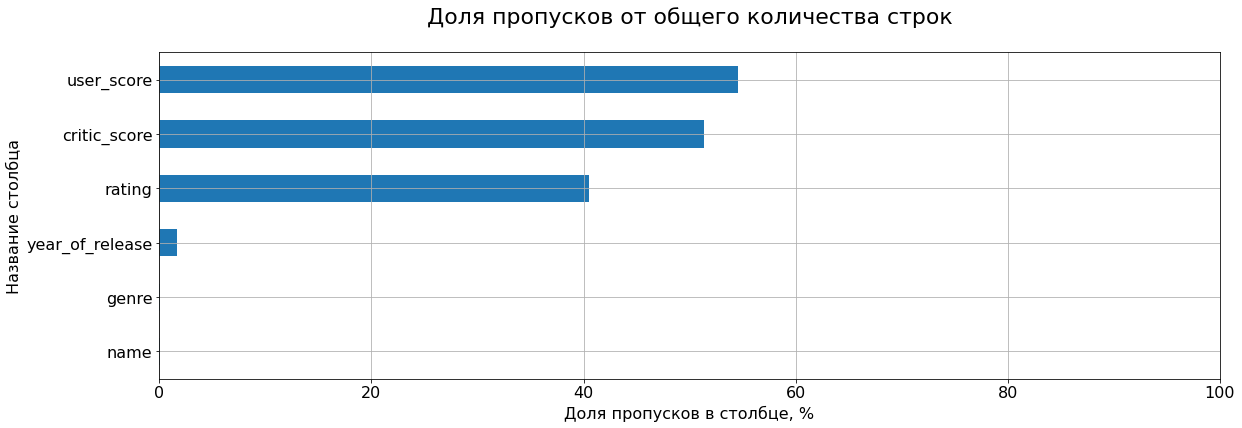

In [116]:
pass_value_barh_1(data)

Выведем строки с пропусками в столбце `name`.

In [117]:
data[data['name'].isna() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Судя по содержимому строк, это могут быть как две игры с несохранишимися данными, так и "потерявшиеся" продажи какой-то другой игры. По имеющейся информации определить невозможно, поэтому предлагаю удалить эти строки.

In [118]:
data = data[data['name'].isna() == False].reset_index(drop=True) #удаление строк и обновление индексов
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


Почему еще могли образоваться пропуски:
- в столбцах с оценками: игра либо не успела накопить оценки, либо недостаточно популярна, либо возможность оценить не была предоставлена
- в столбце с годом релиза: информация неизвестна
- во всех столбцах с пропусками: информация не сохранилась/не подтянулась по техническим причинам

Для принятия решения о заполнении пропусков в столбце `rating` было бы полезно знать причину образования пропусков в этом столбце наверняка. Поскольку узнать точную причину в рамках проекта мы не можем, предположим, что пустые значения подразумевают изначальное отсутствие рейтинга у игры. Т.е. пользователь покупал игру без какого-либо рейтинга. 

В таком случае пропуски в столбце `rating` можно заполнить некоторым значением и анализировать его, как отдельную категорию. Выберем для пропусков значение 'unknown'.

In [119]:
data['rating'] = data['rating'].fillna('unknown') #заполнение пропусков
print('Осталось пропусков:', data['rating'].isna().sum()) #проверка, подсчет пропусков в столбце
data['rating'].unique() #проверка, вывод уникальных значений в столбце

Осталось пропусков: 0


array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

Заполнение пропусков в остальных столбцах не представляется возможным, удаление строк с пропусками в этих столбцах приведет к потере слишком большого количества данных, поэтому предлагаю оставить их как есть.

#### Обработка дубликатов

Начнем с обработки неявных дубликатов. Они могут содержаться в столбцах `genre`, `platform` и, возможно, `rating`. Проверим списки уникальных значений в этих столбцах.

In [120]:
data['genre'] = data['genre'].str.lower() #приведение названий к нижнему регистру
data['genre'].sort_values().unique() #вывод списка уникальных значений в столбце

array(['action', 'adventure', 'fighting', 'misc', 'platform', 'puzzle',
       'racing', 'role-playing', 'shooter', 'simulation', 'sports',
       'strategy'], dtype=object)

In [121]:
data['platform'] = data['platform'].str.lower() #приведение названий к нижнему регистру
data['platform'].sort_values().unique() #вывод списка уникальных значений в столбце

array(['2600', '3do', '3ds', 'dc', 'ds', 'gb', 'gba', 'gc', 'gen', 'gg',
       'n64', 'nes', 'ng', 'pc', 'pcfx', 'ps', 'ps2', 'ps3', 'ps4', 'psp',
       'psv', 'sat', 'scd', 'snes', 'tg16', 'wii', 'wiiu', 'ws', 'x360',
       'xb', 'xone'], dtype=object)

In [122]:
data['rating'] = data['rating'].str.lower() #приведение названий к нижнему регистру
data['rating'].sort_values().unique() #вывод списка уникальных значений в столбце

array(['ao', 'e', 'e10+', 'ec', 'k-a', 'm', 'rp', 't', 'unknown'],
      dtype=object)

Значение рейтинга K-A является неявным дубликатом рейтинга E. Это старое название, которое поменяли в 1998 году, поэтому заменим K-A на Е.

In [123]:
data['rating'] = data['rating'].replace('k-a', 'e') #замена значения
data['rating'].sort_values().unique() #вывод списка уникальных значений в столбце

array(['ao', 'e', 'e10+', 'ec', 'm', 'rp', 't', 'unknown'], dtype=object)

Проверим наличие неполных дубликатов по ключевым столбцам `name`, `platform` и `year_of_release` на случай, если, например, продажи одной и той же игры записались в разные строки.

In [124]:
data['name'] = data['name'].str.lower() #приведение названий к нижнему регистру
data.duplicated(subset=['name', 'platform', 'year_of_release']).sum()


1

Дубликат есть. Посмотрим, что это за игра, и сравним 2 строки.

In [125]:
display(data[data.duplicated(subset=['name', 'platform', 'year_of_release']) == True])
data.query('name == "madden nfl 13" and platform =="ps3" and year_of_release == 2012')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16228,madden nfl 13,ps3,2012,sports,0.0,0.01,0.0,0.0,83.0,5.5,e


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,madden nfl 13,ps3,2012,sports,2.11,0.22,0.0,0.23,83.0,5.5,e
16228,madden nfl 13,ps3,2012,sports,0.00,0.01,0.0,0.00,83.0,5.5,e


В строку-дубликат записались продажи в Европе, основная часть данных в строке 604. Прибавим продажи из строки-дубликата к основной строке и удалим дубликат.

In [126]:
data.loc[604, 'eu_sales'] = data.loc[604, 'eu_sales'] + data.loc[16228, 'eu_sales']
#перенос продаж в Европе из дубликата в оригинал
data.query('index == 604') #проверка

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,madden nfl 13,ps3,2012,sports,2.11,0.23,0.0,0.23,83.0,5.5,e


Теперь удалим дубликат и проверим, что количество строк уменьшилось c 16713 до 16712. 

In [127]:
data = data.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep='first').reset_index(drop=True)
#удаление дубликата
len(data)

16712

Теперь проверим, есть ли явные дубликаты.

In [128]:
data.duplicated().sum() #подсчет количества явных дубликатов

0

Явных дубликатов нет. 

#### Добавление столбца с суммой продаж по всем регионам

Далее нам понадобится столбец с общим количеством продаж. Для этого достаточно посчитать сумму по `na_sales`, `eu_sales`, `jp_sales` и `other_sales` и сохранить ее в отдельный столбец.

In [129]:
data['all_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
#создание столбца с суммой продаж
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,e,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,e,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


In [130]:
#проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16712 entries, 0 to 16711
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16712 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16712 non-null  object 
 4   na_sales         16712 non-null  float64
 5   eu_sales         16712 non-null  float64
 6   jp_sales         16712 non-null  float64
 7   other_sales      16712 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       7589 non-null   float64
 10  rating           16712 non-null  object 
 11  all_sales        16712 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.5+ MB


### Исследовательский анализ данных

#### Количество игр по годам

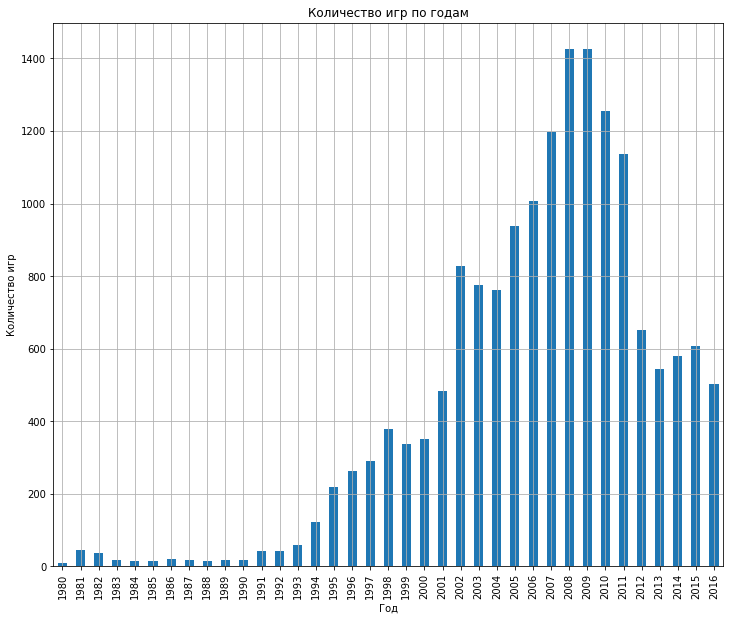

In [131]:
#построение столбчатой диаграммы
data.pivot_table(index='year_of_release', values='name', aggfunc='count').plot\
.bar(figsize=(12, 10), grid=True, legend=False)
plt.title("Количество игр по годам")
plt.xlabel("Год")
plt.ylabel("Количество игр")
plt.show()

До 1995 года выпускалось очень мало игр. Вряд ли эти данные помогут с прогнозом на 2017 год.

#### Продажи на топовых платформах по годам

Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. 

Сначала отсортируем платформы по суммарным продажам от большего к меньшему. 

In [132]:
platform_sales = data.pivot_table(index='platform', values='all_sales', aggfunc='sum')\
.sort_values(by='all_sales', ascending=False).reset_index()
platform_sales

,platform,all_sales
0,ps2,1255.77
1,x360,971.42
2,ps3,939.65
3,wii,907.51
4,ds,806.12
5,ps,730.86
6,gba,317.85
7,ps4,314.14
8,psp,294.05
9,pc,259.52


Для выбора топовых платформ в качестве нижней границы предлагаю взять значение в 100 миллионов копий.

In [133]:
top_platform = platform_sales.query('all_sales > 100')['platform'] #формирование списка названий топовых платформ

Отфильтруем данные для дальнейшего анализа, оставив в таблице только те платформы, что вошли в список выше.

In [134]:
top_platform_sales = data.query('platform in @top_platform')\
.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum') 
#создание таблицы только для топовых платформ
top_platform_sales

platform,3ds,ds,gb,gba,gc,n64,nes,pc,ps,ps2,ps3,ps4,psp,snes,wii,x360,xb,xone
year_of_release,,,,,,,,,,,,,,,,,,
1983,NaN,NaN,NaN,NaN,NaN,NaN,10.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,50.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,0.02,NaN,NaN,NaN,NaN,53.44,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,36.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,19.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,1.43,NaN,NaN,NaN,45.01,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,NaN,NaN,64.97,NaN,NaN,NaN,7.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,NaN,NaN,4.89,NaN,NaN,NaN,15.73,NaN,NaN,NaN,NaN,NaN,NaN,26.15,NaN,NaN,NaN,NaN
1991,NaN,NaN,5.57,NaN,NaN,NaN,6.11,NaN,NaN,NaN,NaN,NaN,NaN,16.22,NaN,NaN,NaN,NaN


У Nintendo DS есть продажи за 1985 год, хотя сама консоль была выпущена только в 2004 году.  

In [135]:
data.query('platform == "ds" and year_of_release == 1985') #вывод строки с аномалией

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
15955,strongest tokyo university shogi ds,ds,1985,action,0.0,0.0,0.02,0.0,NaN,NaN,unknown,0.02


В строке явно ошибка с годом выпуска игры. У игры нет ни рейтинга, ни оценок, и относительно немного продаж. Строку можно удалить.

In [136]:
ds_an = data.query('platform == "ds" and year_of_release == 1985').index #получение индекса строки с аномалией
data = data.drop(ds_an).reset_index(drop=True) #удаление строки с аномалией и обновление индексов
data.info() #проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16711 entries, 0 to 16710
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16711 non-null  object 
 1   platform         16711 non-null  object 
 2   year_of_release  16442 non-null  Int64  
 3   genre            16711 non-null  object 
 4   na_sales         16711 non-null  float64
 5   eu_sales         16711 non-null  float64
 6   jp_sales         16711 non-null  float64
 7   other_sales      16711 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       7589 non-null   float64
 10  rating           16711 non-null  object 
 11  all_sales        16711 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.5+ MB


Теперь построим графики распределения продаж на платформах по годам.

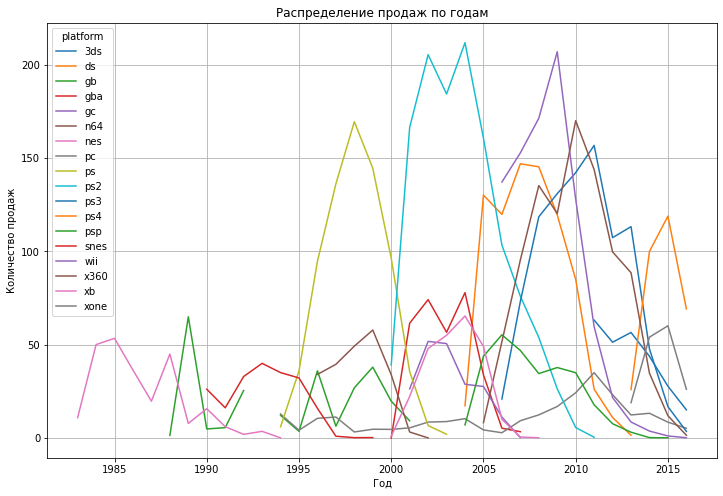

In [137]:
top_platform_sales.plot(figsize=(12, 8), grid=True)
plt.title("Распределение продаж по годам")
plt.xlabel("Год")
plt.ylabel("Количество продаж")
plt.show()

И по таблице `top_platform_sales`, и по графику прослеживается ограниченный период активности платформ, который составляет примерно 10 лет, но есть и исключения, например, PC, которая пусть и понемногу, но стабильно генерит продажи. 

Также обращают на себя внимание цифры по продажам за 2016 год. Они сильно ниже по всем основным активным платформам, при этом вряд ли имеет место резкий спад, больше похоже на влияние неполноты данных за этот год.

За <b>актуальный для прогноза период предлагаю взять данные с 2014</b>, чтобы:
- прослеживать текущий тренд на спад, или рост
- не захватывать данные по уже не актуальным платформам

In [138]:
data = data.query('2014 <= year_of_release').reset_index(drop=True) #срез данных за выбранный период
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
1,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,m,12.62
2,pokemon omega ruby/pokemon alpha sapphire,3ds,2014,role-playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,11.68
3,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,82.0,4.3,e,8.58
4,star wars battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
1684,strawberry nauts,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
1685,aiyoku no eustia,psv,2014,misc,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
1686,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
1687,haitaka no psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01


In [139]:
len_before = 16713
len_after = len(data)
print('Всего строк за актуальный период:', len_after)
print('Доля строк за актуальный период от изначального количества:', f"{(len_after / len_before):.2%}")

Всего строк за актуальный период: 1689
Доля строк за актуальный период от изначального количества: 10.11%


Строк в датафрейме стало значительно меньше, но все же должно хватить для дальнейшего анализа.

#### Выбор потенциально прибыльных платформ

Еще раз выведем список платформ, отсортированных по убыванию продаж, но уже за актуальный период.

In [140]:
platform_sales_actual = data.groupby('platform').agg({'all_sales':'sum'})\
.sort_values(by='all_sales', ascending=False).reset_index()
platform_sales_actual

,platform,all_sales
0,ps4,288.15
1,xone,140.36
2,3ds,86.68
3,ps3,68.18
4,x360,48.22
5,wiiu,42.98
6,pc,27.05
7,psv,22.40
8,wii,5.07
9,psp,0.36


Чтобы отследить динамику продаж, создадим сводную таблицу и построим график продаж по годам.

In [141]:
data.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum') 
#создание сводной таблицы с продажами на платформах по годам

platform,3ds,pc,ps3,ps4,psp,psv,wii,wiiu,x360,xone
year_of_release,,,,,,,,,,
2014,43.76,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


Из таблицы уже видно, что PSP и Wii не войдут в список потенциально прибыльных платформ. Теперь посмотрим на график.

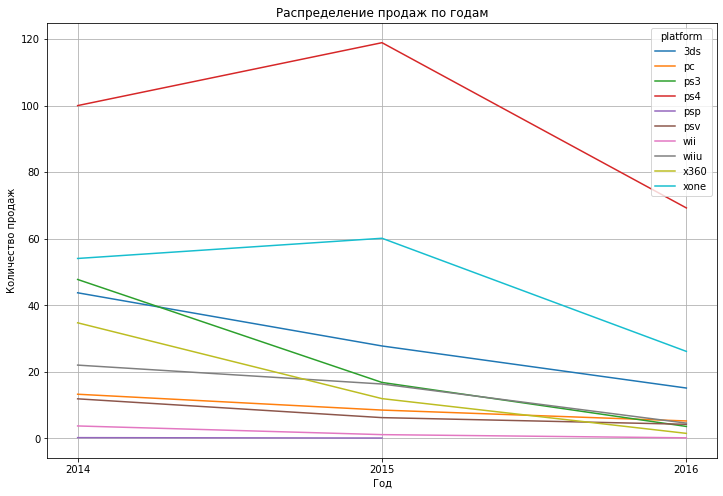

In [142]:
data.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum')\
.plot(figsize=(12, 8), grid=True)
plt.locator_params (axis='x', nbins=3)
plt.title("Распределение продаж по годам")
plt.xlabel("Год")
plt.ylabel("Количество продаж")
plt.show()

В плане потенциала сильно выделяется PS4, которая находится в фазе роста, и есть все основания полагать, что в 2017 году рост продолжится. 

Также в качестве потенциально прибыльной платформы можно выделить XOne, которая тоже находится в фазе роста. 

Все остальные платформы либо падают по продажам, либо находятся на относительно низком уровне. Но можно все же оставить в фокусе внимания:
- 3DS — динамика спада не такая резкая, и есть шанс, что уровень продаж в 2017 году будет в районе 10 млн. копий
- Wii U — тренд на спад за последние 3 года достаточно слабый, в 2017 еще можно будет рассчитывать на продажи около 5-6 млн. копий
- PC — нулевых продаж по этой платформе не было аж с 1994 года, что мы выяснили в предыдущем пункте, и слишком резкого спада на графике не видно

<b>Вывод:</b> наиболее перспективные в плане прибыли платформы — PS4 и XOne. При наличии ресурсов дополнительно можно брать в работу продукты на 3DS, PC, Wii U. 

#### Анализ продаж на платформах

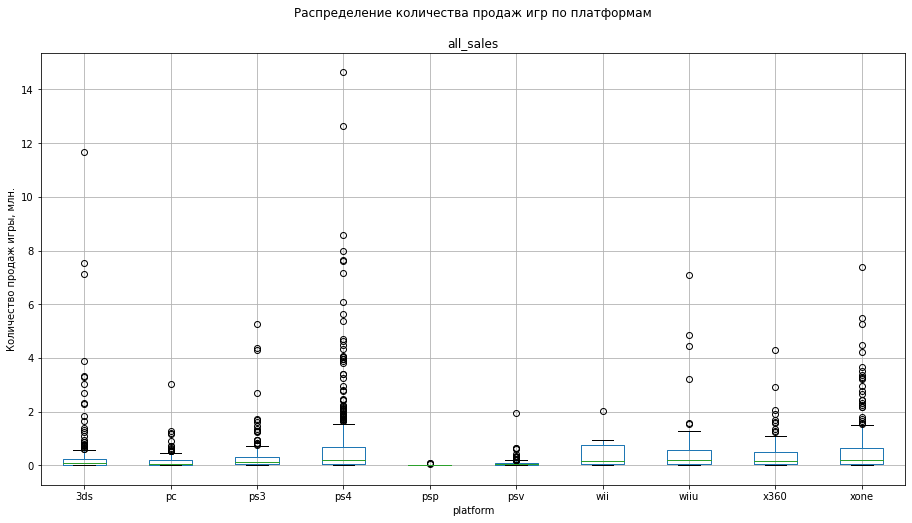

In [143]:
data.boxplot(column='all_sales', by='platform', figsize=(15, 8)) #построение диаграммы размаха
plt.suptitle("Распределение количества продаж игр по платформам")
plt.ylabel("Количество продаж игры, млн.")
plt.show()

Самые сильные выбросы, которые представляют собой игры с рекордными продажами, наблюдаются у платформ PS4, 3DS, XOne, Wii U. Для более детального рассмотрения "ящика" построим ту же диаграмму в другом масштабе.

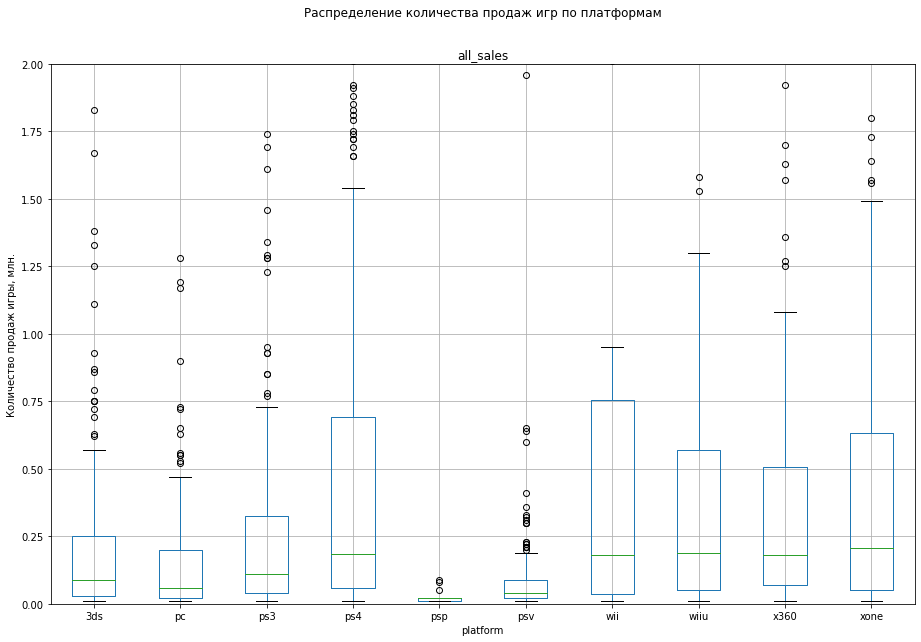

In [144]:
top_pl = data.boxplot(column='all_sales', by='platform', figsize=(15, 10)) #построение диаграммы размаха в другом масштабе
top_pl.set_ylim(0, 2)
plt.suptitle("Распределение количества продаж игр по платформам")
plt.ylabel("Количество продаж игры, млн.")
plt.show()

По диаграмме размаха можно сделать вывод, что стабильно высоких продаж можно ожидать от игр на PS4, XOne и Wii U.

Данные, полученные с помощью диаграмм, в целом, подтверждают выводы по предыдущему пункту. Исключением стала платформа PC, которая не приносить стабильно высоких продаж, но ее плюс в том, что ее жизненный цикл самый длинный.

#### Связь между отзывами и продажами

Создадим функцию для подсчета корреляции между продажами и отзывами и отрисовки графиков.

In [145]:
def corr_platform_user(platform_name): 
#функция для расчета коэффициентов корреляции продаж с оценками и построения графиков для конкретной платформы
    try:
        corr_data = data.query('platform == @platform_name').reset_index(drop=True)
        corr_data.plot(x='critic_score', y='all_sales', kind='scatter', alpha=0.3)
        plt.title(f"Зависимость продаж на {platform_name} от оценок критиков")
        plt.xlabel("Оценка")
        plt.ylabel("Количество продаж")
        plt.show()
        print('Коэффициент корреляции между оценкой критиков и продажами', 
              round(corr_data['all_sales'].corr(corr_data['critic_score']), 4))
        corr_data.plot(x='user_score', y='all_sales', kind='scatter', alpha=0.3)
        plt.title(f"Зависимость продаж на {platform_name} от оценок пользователей")
        plt.xlabel("Оценка")
        plt.ylabel("Количество продаж")
        plt.show()
        print('Коэффициент корреляции между оценкой пользователей и продажами', 
              round(corr_data['all_sales'].corr(corr_data['user_score']), 4))
    except:
        print('Что-то не так с данными на входе')

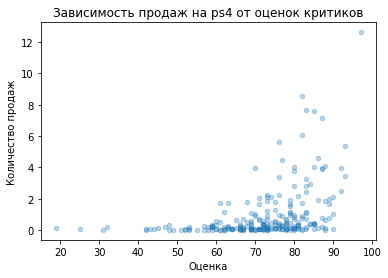

Коэффициент корреляции между оценкой критиков и продажами 0.4027


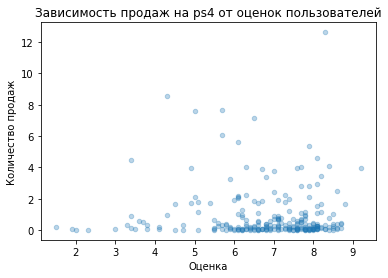

Коэффициент корреляции между оценкой пользователей и продажами -0.0401


In [146]:
corr_platform_user('ps4') #применение функции для данных по ps4

Судя по значению коэффициента корреляции, для PS4 связь между оценками критиков и продажами есть, но не слишком сильная. Но не у всех игр с высокими оценками много продаж. А вот оценки пользователей не влияют однозначно.

Проверим, справедливо ли это и для остальных потенциально прибыльных платформ.

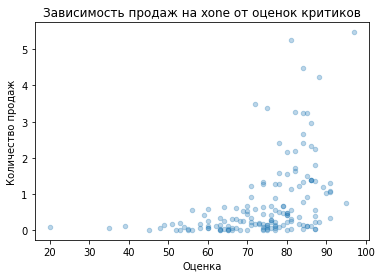

Коэффициент корреляции между оценкой критиков и продажами 0.4287


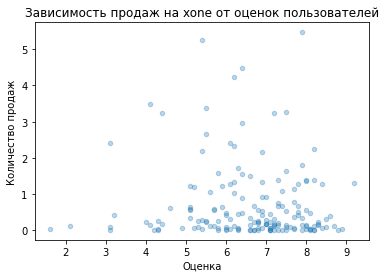

Коэффициент корреляции между оценкой пользователей и продажами -0.0704


In [147]:
corr_platform_user('xone') #применение функции для данных по xone

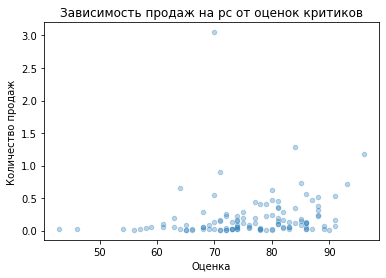

Коэффициент корреляции между оценкой критиков и продажами 0.1746


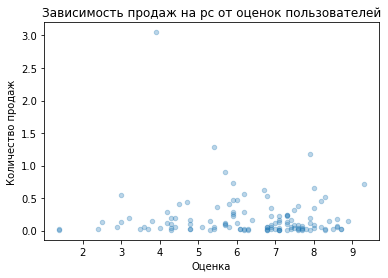

Коэффициент корреляции между оценкой пользователей и продажами -0.0716


In [148]:
corr_platform_user('pc') #применение функции для данных по pc

Для XOne справедливы те же выводы, что и для PS4 — связь между оценками критиков и продажами есть, но не слишком сильная, а оценки пользователей с продажами не связаны. 

PC и здесь немного отличается от остальных — связь оценок критиков с продажами слабая, но связь продаж с оценками пользователей отсутствует так же, как и у остальных.

Поскольку PC, как мы выяснили ранее, отличается от остальных платформ, возьмем за основу выводы по XOne и PS4.

<b>Вывод:</b> связь между оценками критиков и продажами не слишком сильная, а связи оценки пользователей с продажами нет.

#### Распределение игр по жанрам

In [149]:
genre_sales = data.pivot_table(index='genre', values='all_sales', aggfunc=['count', 'sum', 'mean'])
genre_sales.columns = ['sales_count', 'sales_sum', 'sales_by_game']
genre_sales['sales_by_game'] = round(genre_sales['sales_by_game'], 2)
genre_sales.sort_values(by='sales_sum', ascending=False)

,sales_count,sales_sum,sales_by_game
genre,,,
action,619,199.36,0.32
shooter,128,170.94,1.34
sports,161,109.48,0.68
role-playing,221,101.44,0.46
misc,113,37.55,0.33
fighting,60,28.22,0.47
racing,69,27.52,0.40
platform,38,18.09,0.48
adventure,185,17.55,0.09


По абсолютным значениям продаж лидирует самый многочисленный по количеству игр жанр action, а меньше всего продаж за рассматриваемый период принес жанр puzzle. 

В дополнение к абсолютным значениям можно учесть и количество продаж на игру (столбец `sales_by_game`). По этим значениям можно сделать вывод, что лучше всего продаются игры жанра shooter, а хуже всего — adventure, strategy и puzzle. Жанр action выигрывает по количеству продаж за счет количества игр.

Построим диаграммы размаха, чтобы посмотреть какое количество продаж "типично" для каждого жанра и что является редкими выбросами.

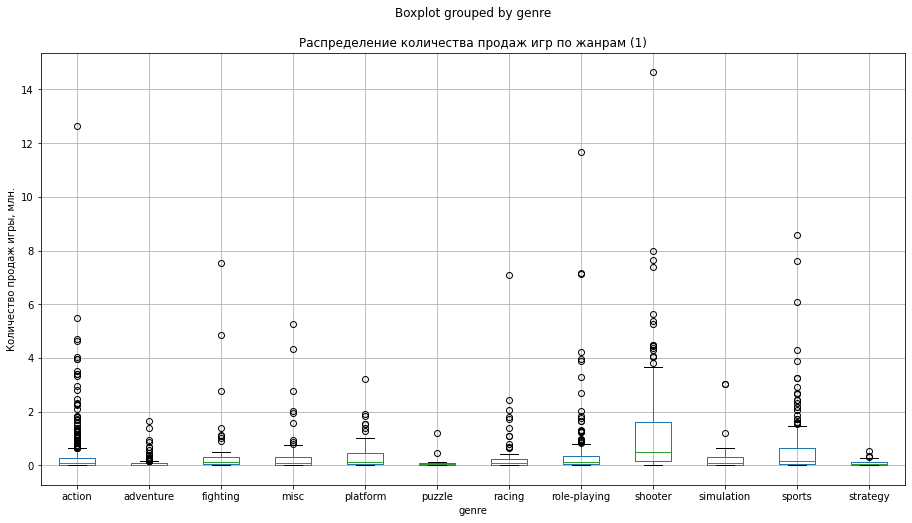

In [150]:
data.boxplot(column='all_sales', by='genre', figsize=(15, 8)) #построение диаграммы размаха
plt.title("Распределение количества продаж игр по жанрам (1)")
plt.ylabel("Количество продаж игры, млн.")
plt.show()

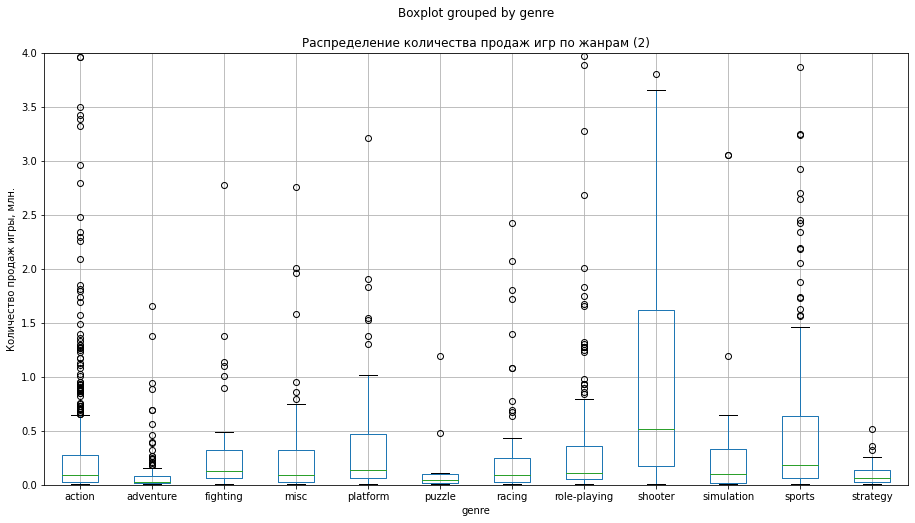

In [151]:
genre_pl = data.boxplot(column='all_sales', by='genre', figsize=(15, 8)) 
#построение диаграммы размаха в другом масштабе
genre_pl.set_ylim(0, 4)
plt.title("Распределение количества продаж игр по жанрам (2)")
plt.ylabel("Количество продаж игры, млн.")
plt.show()

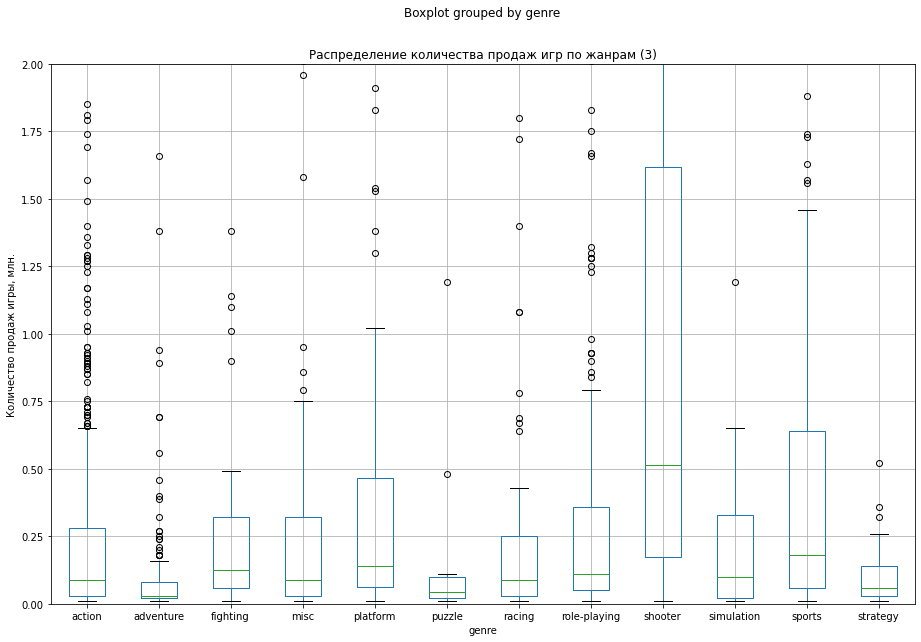

In [152]:
genre_pl = data.boxplot(column='all_sales', by='genre', figsize=(15, 10)) 
#построение диаграммы размаха в другом масштабе
genre_pl.set_ylim(0, 2)
plt.title("Распределение количества продаж игр по жанрам (3)")
plt.ylabel("Количество продаж игры, млн.")
plt.show()

У игр жанра shooter самое высокое медианное значение по продажам — примерно 0.6 млн. продаж, а верхняя граница нормальных значений достигает примерно 3.6 млн. продаж. Следовательно, игры этого жанра стабильно могут показывать самые высокие результаты по сравнению с остальными.

Самое низкое медианное значение у жанра adventure примерно — 0.05 млн. продаж. Верхняя граница нормальных значений — около 0.2 млн. продаж.

<b>Вывод:</b> лучше всего продаются игры жанра shooter, а хуже всего — adventure. Наибольшее количество продаж приносит жанр action, наименьшее — жанр puzzle.

<b>Вывод по разделу:</b>
- жизненный цикл игровой платформы составляет примерно 10 лет (исключение PC)
- наиболее перспективные в плане прибыли платформы — PS4 и XOne, при наличии ресурсов дополнительно можно брать в работу продукты на 3DS, PC, Wii U
- связь между оценками критиков и продажами не слишком сильная, а связи оценки пользователей с продажами нет
- лучше всего продаются игры жанра shooter, а хуже всего — adventure и puzzle, по количеству продаж лидирует жанр action

### Анализ продаж по регионам

#### Топ-5 платформ в регионах

Определим топ-5 платформ по продажам в каждом из регионов. Чтобы упростить процесс, создадим функцию, создающую список из топ-5 любых интересующих значений.

In [153]:
def top_region(top_of, region_sales): 
    #функция для вывода суммы продаж по топ-5 платформ по региону и суммы по остальным платформам 
    try:    
        reg_sales = data.pivot_table(index=top_of, values=region_sales, aggfunc=['sum']).reset_index()
        #таблица с суммарными продажами в регионе
        reg_sales.columns = [top_of, region_sales] 
        reg_sales_top = reg_sales.sort_values(by=region_sales, ascending=False).head()
        #таблица с топ-5 по продажам в регионе
        reg_top = list(reg_sales_top[top_of].reset_index(drop=True))
        #создание списка с названиями топ-5 
            
        for pl in reg_sales[top_of]: #цикл с заменой названий, не вошедших в топ, на other
            if pl not in reg_top:
                reg_sales = reg_sales.replace(pl, 'other')
            
        reg_sales_pivot = reg_sales.pivot_table(index=top_of, values=region_sales, aggfunc=['sum'])\
        .sort_values(by=('sum', region_sales), ascending=False).reset_index()
        #создание сводной таблицы с суммарными продажами по other и топ-5 
        return reg_sales_pivot
    except:
        print('Убедись, что на вход корректно подано название столбцов (строковый формат), или проверь код функции')

In [154]:
top_platform_na = top_region('platform', 'na_sales') #применение функции к данным по платформам в Северной Америке
top_platform_eu = top_region('platform', 'eu_sales') #применение функции к данным по платформам в Европе
top_platform_jp = top_region('platform', 'jp_sales') #применение функции к данным по платформам в Японии
display(top_platform_na) 
display(top_platform_eu)
top_platform_jp

,platform,sum
,,na_sales
0,ps4,98.61
1,xone,81.27
2,other,31.19
3,x360,28.30
4,3ds,22.64
5,ps3,22.05


,platform,sum
,,eu_sales
0,ps4,130.04
1,xone,46.25
2,other,34.76
3,ps3,25.54
4,pc,17.97
5,3ds,16.12


,platform,sum
,,jp_sales
0,3ds,44.24
1,ps4,15.02
2,psv,14.54
3,ps3,11.22
4,wiiu,7.31
5,other,0.76


По полученным сводным таблицам построим графики — круговые диаграммы, отображающие доли продаж по платформам.

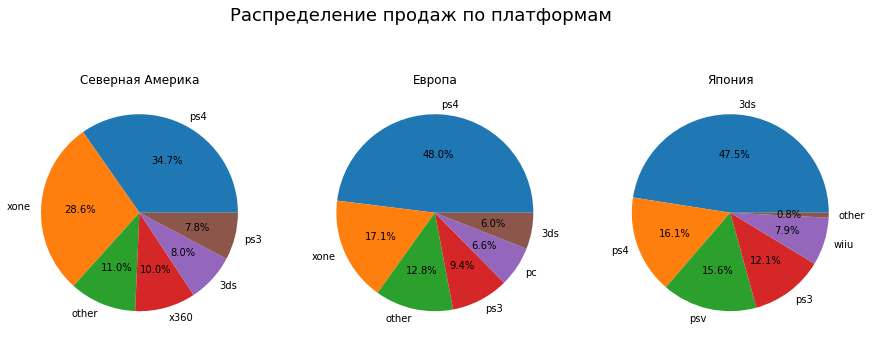

In [155]:
#построение круговых диаграмм с рапределением продаж по платформам в регионах
plt.figure(figsize=[15, 6])
plt.suptitle("Распределение продаж по платформам", fontsize=18)

ax_na = plt.subplot(1,3,1)
ax_na.pie(top_platform_na[('sum', 'na_sales')], labels=top_platform_na['platform'], autopct='%1.1f%%')
plt.title("Северная Америка")

ax_eu = plt.subplot(1,3,2)
ax_eu.pie(top_platform_eu[('sum', 'eu_sales')], labels=top_platform_eu['platform'], autopct='%1.1f%%')
plt.title("Европа")

ax_jp = plt.subplot(1,3,3)
ax_jp.pie(top_platform_jp[('sum', 'jp_sales')], labels=top_platform_jp['platform'], autopct='%1.1f%%')
plt.title("Япония")
plt.show()

В Северной Америке PlayStation и Xbox делят рынок практически пополам. Первые места в топе занимают растущие PS4 и XOne. 

В Европе явно отдают предпочтение PlayStation, а именно новой PS4.

В Японии держит позиции Nintendo 3DS, а уже после идет PlayStation. За рассматриваемый период еще сохраняет популярность PS3, но PS4 уже вошла в топ. Xbox в Японии не популярен совершенно. Возможно, пользователи предпочитают исключительно японских производителей.

#### Топ-5 жанров в регионах

Создадим сводные таблицы с топ-5 жанров по продажам и суммой продаж по остальным жанрам с помощью функции `top_region`.

In [156]:
#вывод топ-5 жанров по медианным продажам для каждого из регионов
top_genre_na = top_region('genre', 'na_sales') #применение функции к данным по жанрам в Северной Америке
top_genre_eu = top_region('genre', 'eu_sales') #применение функции к данным по жанрам в Европе
top_genre_jp = top_region('genre', 'jp_sales') #применение функции к данным по жанрам в Японии
display(top_genre_na) 
display(top_genre_eu)
top_genre_jp

,genre,sum
,,na_sales
0,shooter,79.02
1,action,72.53
2,sports,46.13
3,other,37.86
4,role-playing,33.47
5,misc,15.05


,genre,sum
,,eu_sales
0,action,74.68
1,shooter,65.52
2,sports,45.73
3,other,42.45
4,role-playing,28.17
5,racing,14.13


,genre,sum
,,jp_sales
0,role-playing,31.16
1,action,29.58
2,other,15.50
3,fighting,6.37
4,misc,5.61
5,shooter,4.87


Построим круговые диаграммы по полученным таблицам. С помощью них мы узнаем долю рынка, занимаемую каждым из жанров в отдельном регионе.

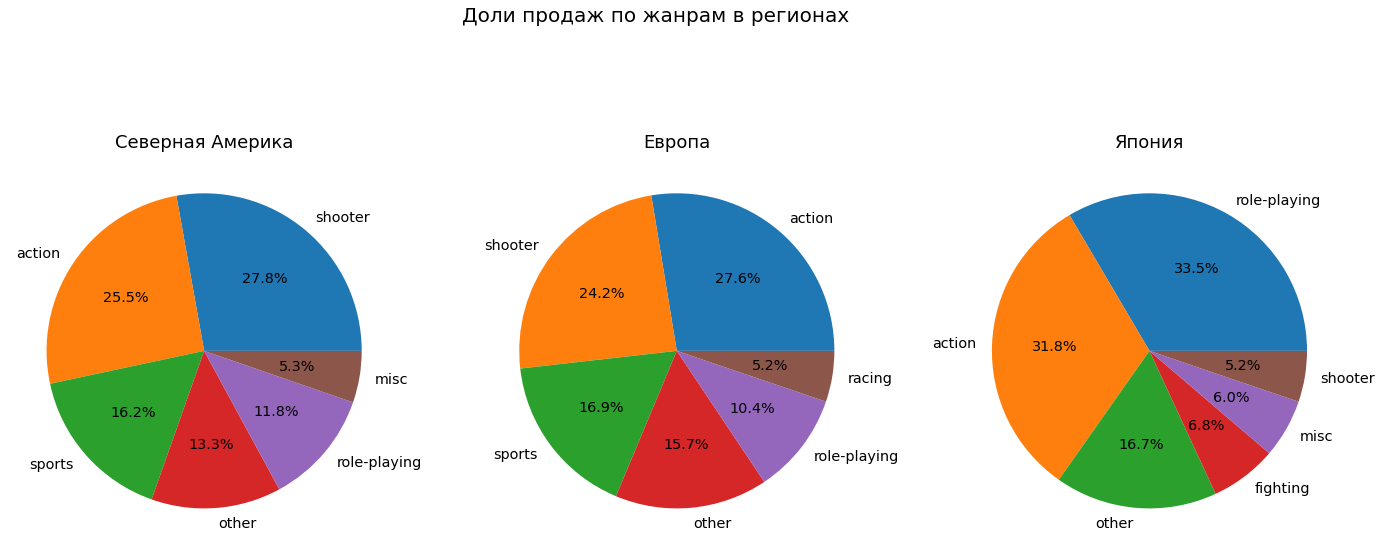

In [157]:
#построение диаграмм с распределением медианных продаж по жанрам в регионах
plt.figure(figsize=[24, 10])
plt.suptitle("Доли продаж по жанрам в регионах", fontsize=20)

ax_genre_na = plt.subplot(1,3,1)
ax_genre_na.pie(top_genre_na[('sum', 'na_sales')], labels=top_genre_na['genre'], autopct='%1.1f%%',\
                textprops={'size': 'x-large'})
plt.title("Северная Америка", fontsize=18)


ax_genre_eu = plt.subplot(1,3,2)
ax_genre_eu.pie(top_genre_eu[('sum', 'eu_sales')], labels=top_genre_eu['genre'], autopct='%1.1f%%',\
                textprops={'size': 'x-large'})
plt.title("Европа", fontsize=18)

ax_genre_jp = plt.subplot(1,3,3)
ax_genre_jp.pie(top_genre_jp[('sum', 'jp_sales')], labels=top_genre_jp['genre'], autopct='%1.1f%%',\
                textprops={'size': 'x-large'})
plt.title("Япония", fontsize=18)
plt.show()

Топы в Северной Америке и Европе очень похожи и отличаются всего одним жанром.
Топ жанров в Японии иной, есть пересечения с другими регионами, но здесь всему остальному предпочитают жанр role-playing.

#### Влияние рейтинга ESRB на продажи по регионам

Дадим расшифровку возрастных категорий:
- EC — для детей младшего возраста. Подходит для детей от 3 лет, неприемлемое содержание отсутствует. Примеры: Дора Исследовательница, Сказки Дракона.
- E	— подходит для всех возрастных категорий. Игра не должна содержать звуков или изображений, которые могут напугать маленьких детей. Не должна использоваться ненормативная лексика. Примеры: Просто таннцуй, FIFA.
- E10+ — подходит для лиц старше 10 лет. Игра может содержать умеренные формы насилия, а некоторые сцены могут пугать детей. Примеры: Minecraft Dungeons, Растения против зомби.
- T	— подходит для лиц старше 13 лет. Игра может содержать более реалистичные и натуралистические сцены насилия. Примеры: Fortnite, Sims 4.
- M	— подходит для лиц старше 17 лет. Этот рейтинг используется, когда насилие становится реалистичным и похожим на реальную жизнь. Также может присутствовать ненормативная лексика, употребление табака, алкоголя или запрещенных наркотиков. Примеры: Ark: Survival Evolved, Destiny 2.
- AO — подходит для взрослых старше 18 лет. Классификация «для взрослых» используется, когда в игре присутствует крайний уровень насилия и немотивированного убийства. Также может присутствовать романтизация наркотиков, азартных игр и сексуальной активности. Примеры: Grand Theft Auto V, Fallout 4.
- RP — категория ещё не присвоена. Играм с категорией RP еще не присвоен окончательный рейтинг ESRB.

Построим график (столбчатую диаграмму), на котором отобразим продажи игр каждого рейтинга по регионам. 

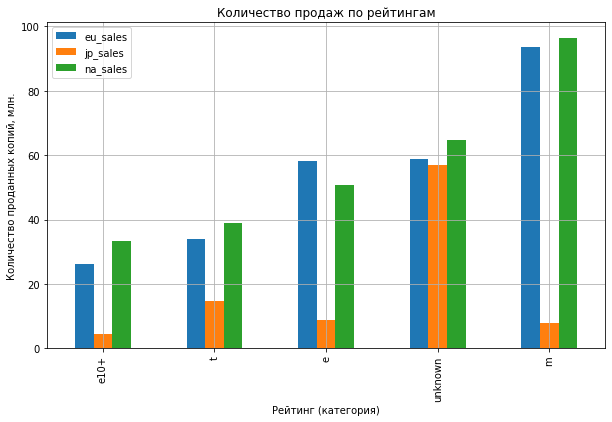

In [158]:
#построение столбчатой диаграммы
data.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')\
.sort_values(by='na_sales').plot.bar(figsize=(10, 6), grid=True)
plt.title("Количество продаж по рейтингам")
plt.xlabel("Рейтинг (категория)")
plt.ylabel("Количество проданных копий, млн.")
plt.show()

На графике можно увидеть схожее распределение продаж по рейтингам в Северной Америке и Европе. Самая продаваемая категория игр в этих регионах с рейтингом M. В Японии распределение совсем иное, в отличие от Северной Америки и Европы, лидируют игры с отсутствием информации о рейтинге.

Весомые различия между Японией и остальными регионами встречаются в каждом пункте. Это можно объяснить очевидной разницей менталитетов. 

<b>Вывод:</b> считаю, что некорректно говорить о влиянии рейтинга на продажи, но, поскольку распределения продаж по категориям в Северной Америке и Европе сильно похожи, то имеет место взаимосвязь между рейтингом и количеством продаж для этих регионов. 

#### Портреты пользователей по регионам

По полученным ранее выводам можно составить некий портрет пользователя для каждого из регионов:
1. Северная Америка: 
- предпочитает XBox, или PlayStation
- предпочитает игры в жанре shooter
- предпочитает игры с рейтингом М (17+)
2. Европа: 
- отдает предпочтение PlayStation 
- предпочитает игры в жанре action
- предпочитает игры с рейтингом М (17+)
3. Япония: 
- отдает предпочтение Nintendo, либо, уже в меньшей степени, PlayStation
- предпочитает игры в жанре role-playing
- предпочитает игры с отсутствием рейтинга

### Проверка гипотез

#### Пользовательские рейтинги платформ Xbox One и PC

Нам нужно проверить гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Для этого сформулируем нулевую и альтернативную гипотезы для проведения статистического теста. Исходную гипотезу возьмем в качестве нулевой, поскольку это гипотеза о равенстве средних двух совокупностей. Альтернативная гипотеза будет противоположна нулевой.

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC равны.

Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC не равны.

Сделаем срезы данных по играм на Xbox One и PC с пользовательскими оценками и для удобства сохраним их в переменные.

In [159]:
xone_data = data.query('platform == "xone" and user_score.isna() == False').reset_index(drop=True) 
#срез данных по платформе Xbox One
pc_data = data.query('platform == "pc" and user_score.isna() == False').reset_index(drop=True) 
#срез данных по платформе PC
print('Размер выборки по Xbox One:', len(xone_data))
print('Размер выборки по PC:', len(pc_data))

Размер выборки по Xbox One: 165
Размер выборки по PC: 122


Размеры выборок и количество оценок достаточны для проведения статистического теста. Проверять будем двустороннюю гипотезу, поскольку мы проверяем гипотезу о неравенстве средних двух генеральных совокупностей, т.е. нас интересуют отклонения, как в меньшую, так и в большую сторону. Поскольку выборки разного размера, в параметрах теста укажем `equal_var=False`.

In [160]:
alpha = 0.05 #уровень значимости 5%
results_platform = st.ttest_ind(xone_data['user_score'], pc_data['user_score'], equal_var=False)
#проводим ttest для двух выборок, проверяем двустороннюю гипотезу, сохраняем результаты в переменную
print('p-значение:', results_platform.pvalue)
print('Средняя оценка Xbox One =', round(xone_data['user_score'].mean(), 2))
print('Средняя оценка PC =', round(pc_data['user_score'].mean(), 2))

if (results_platform.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 0.11601398086668832
Средняя оценка Xbox One = 6.59
Средняя оценка PC = 6.3
Не отвергаем нулевую гипотезу


<b>Вывод:</b> не можем отвергнуть изначальную гипотезу, т.к. разница между средними пользовательскими оценками Xbox One и PC статистически не значима.

#### Пользовательские рейтинги жанров Action и Sports

Нам нужно проверить гипотезу, что средние пользовательские рейтинги жанров Action и Sports разные. Для этого сформулируем нулевую и альтернативную гипотезы для проведения статистического теста. Исходную гипотезу возьмем в качестве альтернативной, поскольку речь идет о неравенстве средних. В качестве нулевой возьмем противоположную, т.е. гипотезу о равенстве средних.

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports равны.

Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports не равны.

In [162]:
action_data = data.query('genre == "action" and user_score.isna() == False').reset_index(drop=True) 
#срез по жанру action
sports_data = data.query('genre == "sports" and user_score.isna() == False').reset_index(drop=True) 
#срез по жанру sports
print('Размер выборки по Action:', len(action_data))
print('Размер выборки по Sports:', len(sports_data))

Размер выборки по Action: 297
Размер выборки по Sports: 127


Размеры выборок и количество оценок достаточны для проведения статистического теста. Проверять будем так же двустороннюю гипотезу о неравенстве средних двух генеральных совокупностей. 

In [163]:
alpha = 0.05 #уровень значимости 5%
results_genre = st.ttest_ind(action_data['user_score'], sports_data['user_score'], equal_var=False)
#проводим ttest для двух выборок, проверяем двустороннюю гипотезу, сохраняем результаты в переменную
print('p-значение:', results_genre.pvalue)
print('Средняя оценка Action =', round(action_data['user_score'].mean(), 2))
print('Средняя оценка Sports =', round(sports_data['user_score'].mean(), 2))

if (results_genre.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 1.1825550382644557e-14
Средняя оценка Action = 6.76
Средняя оценка Sports = 5.23
Отвергаем нулевую гипотезу


<b>Вывод:</b> отвергаем нулевую гипотезу, средние пользовательские оценки игр жанров Action и Sports различаются статистически значимо.

### Общий вывод

<b>Что сделано</b>: 
- проанализированы данные о продажах игр 
- выбраны потенциально прибыльные платформы
- проанализирована связь между продажами и оценками критиков и пользователей
- выявлены лучшие и худшие по продажам жанры игр по всем регионам
- составлены портреты пользователей по регионам
- проверены гипотезы по пользовательским рейтингам

Предварительно в таблице с данными были исправлены типы данных, обработаны пропуски и дубликаты.

<b>Потенциально прибыльные платформы</b>: наиболее перспективные в плане прибыли платформы — PS4 и XOne. При наличии ресурсов дополнительно можно брать в работу продукты на 3DS, PC, Wii U.

<b>Связь между продажами и оценками</b>: связь между оценками критиков и продажами не слишком сильная, а связи оценки пользователей с продажами нет.

<b>Лучший по продажам жанр (по всем регионам)</b>: shooter и action

<b>Худшие по продажам жанры (по всем регионам)</b>: adventure и puzzle

<b>Портреты пользователей, на основе которых можно определить приоритетные игры для продвижения</b>:

1. <i>Северная Америка</i>: 
- предпочитает XBox, или PlayStation
- предпочитает игры в жанре shooter
- предпочитает игры с рейтингом М (17+)
2. <i>Европа</i>: 
- отдает предпочтение PlayStation 
- предпочитает игры в жанре action
- предпочитает игры с рейтингом М (17+)
3. <i>Япония</i>: 
- отдает предпочтение Nintendo, либо, уже в меньшей степени, PlayStation
- предпочитает игры в жанре role-playing
- предпочитает игры с отсутствием рейтинга

<b>Гипотезы и результаты проверки гипотез</b>:

<i>Гипотеза 1.</i> Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Результат: не отвергаем эту гипотезу, т.к. разница между средними пользовательскими оценками Xbox One и PC не статистически значимая.


<i>Гипотеза 2.</i> Средние пользовательские рейтинги жанров Action и Sports разные.

Результат: отвергаем нулевую гипотезу, средние пользовательские рейтинги Xbox One и PC различаются статистически значимо.
